# ----------------- PhotoVoltaic Power Prediction ----------------- 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load data and format columns

In [ ]:
# Load Data
power_df = pd.read_csv("data/EXPORT HourlyData - Customer Endpoints.csv")
weather_df = pd.read_csv("data/london_weather.csv")

In [3]:
# Format datetime
weather_df["datetime"] = pd.to_datetime(weather_df["Date"].astype(str) + " " + weather_df["Time"].astype(str))
power_df["datetime"] = pd.to_datetime(power_df["datetime"])

In [4]:
# Filter src
START_TIME = "2014-03-09 00:00:00"
END_TIME = "2014-06-30 23:00:00"
SUBSTATION = "Forest Road"

weather_df = weather_df[weather_df["Site"]==SUBSTATION]
weather_df = weather_df[
    (weather_df["datetime"]>START_TIME) & (weather_df["datetime"]<END_TIME)
]
power_df = power_df[power_df["Substation"]==SUBSTATION]
power_df = power_df[
    (power_df["datetime"]>START_TIME) & (power_df["datetime"]<END_TIME)
]

In [5]:
# Create target power
power_df["P_GEN"] = ((power_df["P_GEN_MAX"] + power_df["P_GEN_MIN"])/2)*100

In [6]:
# Join power data with weather
joined_df = power_df.merge(weather_df,
                           how="inner",
                           left_on=["Substation", "datetime"],
                           right_on=["Site", "datetime"]) 

## Exploratory Analysis

In [7]:
# Weather Data Head
weather_df.head()


,Site,Date,Time,TempOut,HiTemp,LowTemp,OutHum,DewPt,WindSpeed,WindDir,...,InDew,InHeat,InEMC,InAirDensity,ET,WindSamp,WindTx,ISSRecept,ArcInt,datetime
33968,Forest Road,03/23/2014,14:30,8.3,8.3,7.3,75,4.1,2,ENE,...,2.3,11.9,9.15,0.0758,0.18,702,1,100.0,30,2014-03-23 14:30:00
33969,Forest Road,03/23/2014,15:00,6.4,8.6,6.4,80,3.2,4,ENE,...,2.4,12.1,9.15,0.0757,0.00,703,1,100.0,30,2014-03-23 15:00:00
33970,Forest Road,03/23/2014,15:30,8.6,8.6,6.4,74,4.2,2,ENE,...,2.7,12.1,9.35,0.0758,0.10,702,1,100.0,30,2014-03-23 15:30:00
33971,Forest Road,03/23/2014,16:00,6.5,8.7,6.5,73,2,4,ENE,...,2.7,12.2,9.35,0.0758,0.10,703,1,100.0,30,2014-03-23 16:00:00
33972,Forest Road,03/23/2014,16:30,5.2,6.4,4.7,83,2.5,2,ENE,...,2.8,12.0,9.54,0.0759,0.00,702,1,100.0,30,2014-03-23 16:30:00


In [8]:
# Power Data Head
power_df.head()

,SerialNo,Substation,datetime,t_date,t_time,d_y,d_m,d_d,d_w,t_h,...,Substation_thdVB_MAX_Filtered,Substation_thdVC_MIN_Filtered,Substation_thdVC_MAX_Filtered,V_MAX_Rise_vs_VA_MIN_Filtered,V_MAX_Rise_vs_VA_MAX_Filtered,V_MAX_Rise_vs_VB_MIN_Filtered,V_MAX_Rise_vs_VB_MAX_Filtered,V_MAX_Rise_vs_VC_MIN_Filtered,V_MAX_Rise_vs_VC_MAX_Filtered,P_GEN
2934,3067E69020456129,Forest Road,2014-03-09 01:00:00,2014-03-09,01:00:00,2014,3,9,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
2935,3067E69020456129,Forest Road,2014-03-09 02:00:00,2014-03-09,02:00:00,2014,3,9,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
2936,3067E69020456129,Forest Road,2014-03-09 03:00:00,2014-03-09,03:00:00,2014,3,9,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
2937,3067E69020456129,Forest Road,2014-03-09 04:00:00,2014-03-09,04:00:00,2014,3,9,7,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
2938,3067E69020456129,Forest Road,2014-03-09 05:00:00,2014-03-09,05:00:00,2014,3,9,7,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2


<AxesSubplot:xlabel='datetime'>

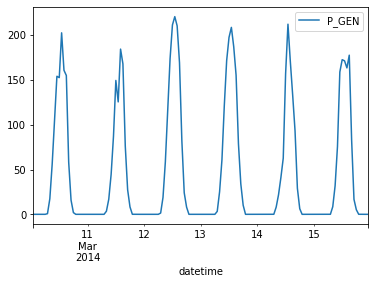

In [9]:
# Power distribution for 5 random days
power_df[
    (power_df["datetime"]>"2014-03-10 00:00:00") 
        & (power_df["datetime"]<"2014-03-15 23:59:59")
].plot(x="datetime", y="P_GEN")

In [10]:
# Columns of weather data
print("Weather Data Columns:")
print(weather_df.columns.to_list())

Weather Data Columns:
['Site', 'Date', 'Time', 'TempOut', 'HiTemp', 'LowTemp', 'OutHum', 'DewPt', 'WindSpeed', 'WindDir', 'WindRun', 'HiSpeed', 'HiDir', 'WindChill', 'HeatIndex', 'THWIndex', 'THSWIndex', 'Bar', 'Rain', 'RainRate', 'SolarRad', 'SolarEnergy', 'HiSolarRad', 'HeatD-D', 'CoolD-D', 'InTemp', 'InHum', 'InDew', 'InHeat', 'InEMC', 'InAirDensity', 'ET', 'WindSamp', 'WindTx', 'ISSRecept', 'ArcInt', 'datetime']


Rain and Temperature over time


<AxesSubplot:xlabel='datetime'>

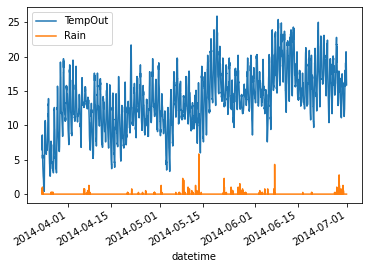

In [11]:
# Rain and Temperature over time
print("Rain and Temperature over time")
weather_df["TempOut"] = weather_df["TempOut"].astype(float)
weather_df["Rain"] = weather_df["Rain"].astype(float)
weather_df.plot(x="datetime", y=["TempOut", "Rain"])

Air-pressure over time


<AxesSubplot:xlabel='datetime'>

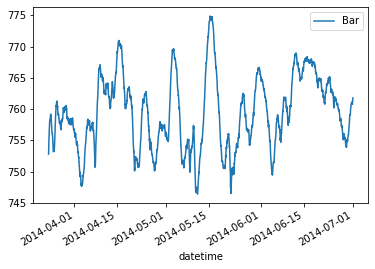

In [12]:
# Air-pressure over time
print("Air-pressure over time")
weather_df["Bar"] = weather_df["Bar"].astype(float)
weather_df.plot(x="datetime", y=["Bar"])

## Set feature and target and Train Test Split

In [13]:
# Set Feature and Target
feature_cols = [
    "RainRate",
    "TempOut",
    "HiTemp",
    "LowTemp",
    "OutHum",
    "DewPt",
    "WindSpeed",
    "WindRun",
    "HiSpeed",
    "WindChill",
    "HeatIndex",
    "Bar",
    "Rain",
    "SolarRad",
    "SolarEnergy",
    "HiSolarRad",
    "HeatD-D",
    "CoolD-D",
    "InTemp",
    "InHum",
    "InDew",
    "InHeat",
    "InEMC",
    "InAirDensity",
    "ET",
    "WindSamp",
    "WindTx",
    "ISSRecept"
]

target_col = ["P_GEN"]

In [14]:
# Convert feature cols to float
for col in feature_cols:
    joined_df[col] = joined_df[col].astype(float)

In [15]:
# Train Test split
X = joined_df[feature_cols]
y = joined_df[target_col].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Build XGBoost Model

In [16]:
# Create model object
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [17]:
# Fit model
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
# Feature importance
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=feature_cols)


,RainRate,TempOut,HiTemp,LowTemp,OutHum,DewPt,WindSpeed,WindRun,HiSpeed,WindChill,...,InTemp,InHum,InDew,InHeat,InEMC,InAirDensity,ET,WindSamp,WindTx,ISSRecept
0,0.00842,0.004239,0.009199,0.009658,0.012766,0.009433,0.004236,0.0,0.007134,0.006148,...,0.019579,0.007861,0.012488,0.026756,0.013708,0.011651,0.009774,0.02713,0.00622,0.0


# Predict

In [19]:
# Predict on test data
y_pred = regressor.predict(X_test)


In [20]:
# RMSE
mean_squared_error(y_test, y_pred)

675.3010420953042

In [21]:
# Predict for single day
DATE = "2014-05-16"
joined_one_day = joined_df[
    (joined_df["datetime"]>"{date} 00:00:00".format(date=DATE)) 
        & (joined_df["datetime"]<"{date} 23:59:59".format(date=DATE))
]
X_one_day = joined_one_day[feature_cols]
y_one_day = joined_one_day[target_col]
y_pred_one_day = regressor.predict(X_one_day)

In [22]:
# RMSE for Mar 09
mean_squared_error(y_one_day, y_pred_one_day)

127.58007480409124

<AxesSubplot:xlabel='datetime'>

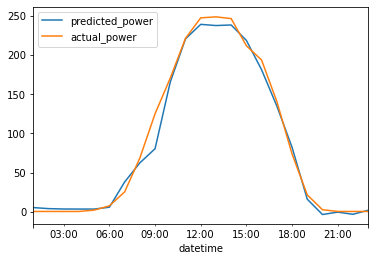

In [23]:
# Plot of actual and predicted power for Mar 09 2014
y_pred_one_day_df = pd.DataFrame(data = y_pred_one_day,  
                      index = y_one_day.index,  
                      columns = ["predicted_power"])
y_pred_one_day_df["actual_power"] = y_one_day[target_col]
y_pred_one_day_df["datetime"] = joined_one_day["datetime"]
y_pred_one_day_df.plot(x="datetime", y=["predicted_power", "actual_power"])

# ------------- Appendix ------------- 

## Weather Data Fields
#### Date		
#### Time		
#### TempOut -	Outdoor Temp	
#### HiTemp -	Outdoor Hi Temp	
#### LowTemp -	Outdoor Low Temp	
#### OutHum -	Outdoor Humidity	
#### DewPt -	Dew Point	
#### WindSpeed -	Wind Speed	
The WeatherLink samples the wind speed reading from the station a number of times during the interval (the actual number depends on your archive interval). Those readings are averaged to determine at the average wind speed for the interval. 
#### WindDir -	Wind Direction	
The WeatherLink samples the wind direction reading a number of times during the interval (the actual number depends on your archive interval). If wind speed is greater than 0 when the WeatherLink samples wind direction, it places a "marker" into one of sixteen "bins" that correspond to the sixteen compass points. At the time of the archive, the WeatherLink determines which bin contains the most markers and writes the corresponding wind direction to the archive memory as the dominant wind direction.
#### WindRun -	Wind Run	
Wind run is a measurement of the "amount" of wind passing the station during a given period of time, expressed in either "miles of wind" or "kilometers of wind". WeatherLink calculates wind run by multiplying the average wind speed for each archive record by the archive interval.
#### HiSpeed -	Hi Wind Speed	
#### HiDir -	Hi Wind Direction	
#### WindChill -	Wind Chill	
#### HeatIndex -	Heat Index	
"The Heat Index uses the temperature and the relative humidity to determine how hot the air actually ""feels."" When humidity is low, the apparent temperature will be lower than the air temperature, since perspiration evaporates rapidly to cool the body. However, when humidity is high (i.e., the air is saturated with water vapor) the apparent temperature ""feels"" higher than the actual air temperature, because perspiration evaporates more slowly.

Note: WeatherLink uses the Steadman (1979 & 1998) formula to calculate Heat Index, which is more accurate than the method used by the Vantage Pro/Vantage Pro2 consoles and is calculated for all temperatures. "
#### THWIndex -	Temperature Humidity Wind (THW) Index	
The THW Index uses humidity, temperature and wind to calculate an apparent temperature that incorporates the cooling effects of wind on our perception of temperature. 
#### THSWIndex -	Temperature Humidity Sun Wind (THSW) Index	
The THWS Index uses humidity, temperature, the cooling effects of wind and the heating effects of direct solar radiation to calculate an apparent temperature. 
#### Bar -	"Barometric Pressure
The weight of the air that makes up our atmosphere exerts a pressure on the surface of the earth. This pressure is known as atmospheric pressure. Generally, the more air above an area, the higher the atmospheric pressure. This, in turn, means that atmospheric pressure changes with altitude. For example, atmospheric pressure is greater at sea-level than on a mountaintop. To compensate for this difference in pressure at different elevations, and to facilitate comparison between locations with different altitudes, meteorologists adjust atmospheric pressure so that it reflects what the pressure would be if measured at sea-level. This adjusted pressure is known as barometric pressure.

Barometric pressure changes with local weather conditions, making barometric pressure an important and useful weather forecasting tool. High pressure zones are generally associated with fair weather, while low pressure zones are generally associated with poor weather. For forecasting purposes, the absolute barometric pressure value is generally less important than the change in barometric pressure. In general, rising pressure indicates improving weather conditions, while falling pressure indicates deteriorating weather conditions."
#### Rain -	Rainfall	
In calculating both daily and yearly rainfall totals for the software, the WeatherLink checks the total rain register on the station. The WeatherLink compares the current total rain value to the previous total rain entry in the archive memory to determine the amount of rainfall that occurred during the interval.
#### RainRate -	High Rain Rate	
Available for Vantage Vue, Vantage Pro and Vantage Pro2 stations only, the rain rate is calculated by measuring the time interval between each rainfall increment. When there is rainfall within the archive period, the highest measured value is reported. When no rainfall occurs, the rain rate will slowly decay based on the elapse time since the last measured rainfall.
#### SolarRad -	Solar Radiation	
What we call "current solar radiation" is technically known as Global Solar Radiation, a measure of the intensity of the sun’s radiation reaching a horizontal surface. This irradiance includes both the direct component from the sun and the reflected component from the rest of the sky. The solar radiation reading gives a measure of the amount of solar radiation hitting the solar radiation sensor at any given time, expressed in Watts per square meter (W/m2). The value logged by WeatherLink is the average solar radiation measured over the archive interval.
#### SolarEnergy -	Solar Energy	
The amount of accumulated solar radiation energy over a period of time is measured in Langleys. 
1 Langley  = 11.622 Watt-hours per square meter
 = 3.687 BTUs per square foot
 = 41.84 kilojoules per square meter"
#### HiSolarRad -	Hi Solar Radiation	
#### HeatD-D -	Heating Degree-Days	
One heating degree-day is the amount of heat required to keep a structure at 65ºF when the outside temperature remains one degree below the 65ºF threshold for 24 hours. One heating degree-day is also the amount of heat required to keep that structure at 65ºF when the temperature remains 24ºF below that 65º threshold for 1 hour. 
#### CoolD-D -	Cooling Degree-Days	
Likewise, one cooling degree-day is the amount of cooling required to keep a structure at 65ºF when the outside temperature remains one degree above the 65ºF threshold for 24 hours. One cooling degree-day is also the amount of cooling required to keep that structure at 65ºF when the temperature remains 24ºF above that 65º threshold for 1 hour. 
#### InTemp	 -Indoor Temperature	
#### InHum -	Indoor Humidity	
#### InDew -	Indoor Dew Point	
#### InHeat -	Indoor Heat Index	
#### InEMC -	Equilibrium moisture content	
Moisture content in wood affects both the size and strength of lumber. If you know the EMC of the storage or manufacturing area (which is derived using temperature and humidity readings), you can also determine the moisture content of the wood stored there.
#### InAirDensity -	Air Density	
Air Density (the weight of 1 cubic foot or 1 cubic meter of air ) is a valuable tool for racing enthusiasts, because it helps determine the optimal jetting under current weather conditions.
#### ET		
#### WindSamp		
#### WindTx		
#### ISSRecept	ISS Reception Rate	
The ISS Reception rate shows the percentage of wind data packets that have been successfully received by the Vnatage Vue, Vantage Pro or Vantage Pro2 console